In [60]:
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.linear_model import Ridge

## Visualization and Analysis

### Visualization : 

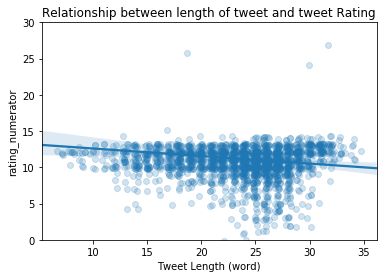

In [61]:
df_master_clean = pd.read_csv('twitter_archive_master.csv')
df_master_filtered = df_master_clean.query('rating_numerator <  250')
sb.regplot(data = df_master_filtered, x = 'tweet_length', y = 'rating_numerator', fit_reg = True,
           x_jitter = 0.3, y_jitter = 0.3, scatter_kws = {'alpha' : 1/5})
plt.ylim(0,30)
plt.title('Relationship between length of tweet and tweet Rating')
plt.xlabel('Tweet Length (word)');

### Analysis :

>There seems to be a very slight negative correlation between tweet length and rating number. Seems like the majority of ratings are above 10 and the shorter the tweet length seems to be a have better rating.

### Visualization :

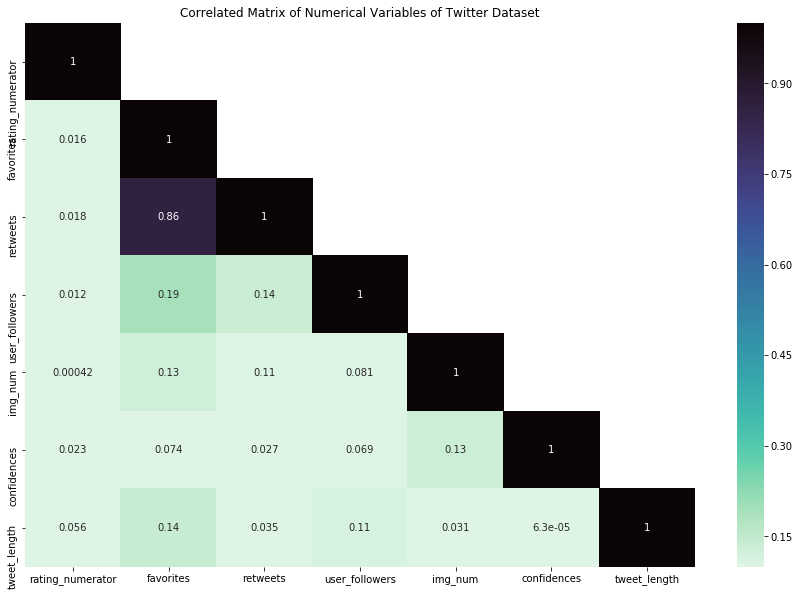

In [62]:
df_numerical = df_master_clean[['rating_numerator', 'favorites','retweets','user_followers','img_num','confidences','tweet_length']]

def lower_corr_matrix(df):
    '''
    calculate a lower correlated matrix from the dataframe numeric variables
    INPUT
    df - dataframe with numeric variables to examine
    OUTPUT
    df_lt - lower correlated matrix
    '''
    corr_matrix = df.corr().abs()
    np.tril(np.ones(corr_matrix.shape)).astype(np.bool)[0:len(corr_matrix),0:len(corr_matrix)]
    df_lt = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(np.bool))
    return df_lt

plt.figure(figsize=(15,10))
sb.heatmap(lower_corr_matrix(df_numerical), annot=True, cmap='mako_r', vmin=0.1, vmax = 1)
plt.title('Correlated Matrix of Numerical Variables of Twitter Dataset');

### Analysis :

>The strongest correlation is between number of favorites and number of retweets. Other seems to have 0 or almost no correlation. The second strongest correlation which is only 0.19 is number of user_followers and number of favorites. The result is still obvious since the more retweets the more favorites the tweet will get. We want to later model this or find other features that could potential be important to predict tweet favorites.


### Visualization :

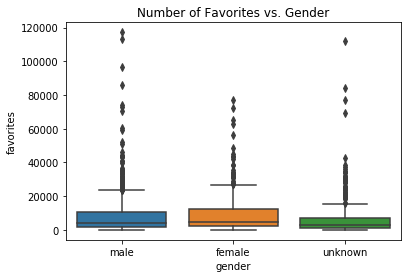

In [63]:
sb.boxplot(x = 'gender', y = 'favorites', data = df_master_clean)
plt.title('Number of Favorites vs. Gender');

### Analysis :

>An analysis of the gender here does not seems to have any relevant infomation to how many favorites the post will get so we will ignore it and not put it in our prediction model.

### Visualization :

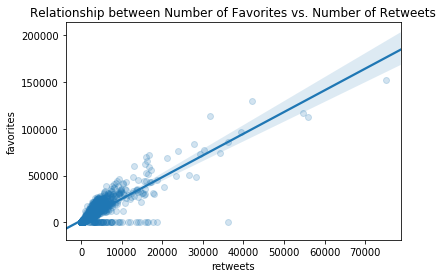

In [64]:
sb.regplot(x = 'retweets', y = 'favorites', data = df_master_clean, fit_reg=True, scatter_kws={'alpha':0.2})
plt.title('Relationship between Number of Favorites vs. Number of Retweets');

### Analysis :

>To confirm our strongest correlation in the matrix we want to examine the relationship between number of favorites vs. number of retweets and seems that the correlation is quite strong. Most retweets are below 10000 but the range could go up 7 fold more which explains how it is possible for certain tweet to go viral. Number of favourties are also between 0-50000 and sometimes it rarely goes up 2-3 fold.

### Modeling:

In [65]:
y = df_master_clean['favorites']
X_col = [col for col in df_numerical if col not in ['favorites']]
X = df_numerical[X_col]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
clf = SVR()


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


### Results:

In [66]:
clf.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [67]:
r2_score_all = r2_score(y_test, y_pred)
print("\nThe r2_score for SVR is {:0.2f}.\n".format(r2_score_all))


The r2_score for SVR is -0.11.



>The model gives a surprisngly bad prediction with r2 score of less than 0, which is worse than guessing. This could be that many features have no correlation to number of favorites. We can try different method of prediction and see whether we get a better result. Since there are many non-correlated features, ridge regression model is used to add penalty (regularization) to the prediction so it is less biased and also reduce the standard errors.

### Modeling :

In [68]:
clf = Ridge(alpha=0.1)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
r2_score = r2_score(y_test,y_pred)

### Result :

In [69]:
clf.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [70]:
print("\nThe r2_score for Ridge Regression is {:0.2f}.\n".format(r2_score))


The r2_score for Ridge Regression is 0.83.



>It turns out the result obtained is significantly higher than SVR. I am not exactly sure why SVR performs worse than guessing. However, the ridge regression proves that with adding penalty to our prediction, we were able to obtain the r2 score of 0.83.